Imports

In [1]:
from parameters_U235 import *
import numpy as np
import matplotlib.pyplot as plt
from jitcdde import t
from msrDynamics.objects import Node, System
import pandas as pd

In [2]:
# unpack simulink data
df_simulink = pd.read_excel("./data/msre_insert_8MW.xlsx")
T = df_simulink["time"]

In [3]:
MSRE = System()

# radiator
T_out_rc = Node(m = mn_rp, scp = mcp_rpn/mn_rp, W = W_rp, y0 = T0_rp)
T_out_air = Node(m = mn_rs, scp = mcp_rsn/mn_rs, W = W_rs, y0 = T0_rs)

# heat exchanger
T_hf1 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p1)
T_hf2 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p2)
T_hf3 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p3)
T_hf4 = Node(m = mn_p, scp = mcp_pn/mn_p, W = W_p, y0 = T0_p4)
T_ht1 = Node(m = m_tn, scp = scp_t, y0 = T0_t1)
T_ht2 = Node(m = m_tn, scp = scp_t, y0 = T0_t2)
T_hc1 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s1)
T_hc2 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s2)
T_hc3 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s3)
T_hc4 = Node(m = mn_s, scp = mcp_sn/mn_s, W = W_s, y0 = T0_s4)

# core 
n = Node(y0 = n_frac0)
C1 = Node(y0 = C0[0])
C2 = Node(y0 = C0[1])
C3 = Node(y0 = C0[2])
C4 = Node(y0 = C0[3])
C5 = Node(y0 = C0[4])
C6 = Node(y0 = C0[5])
rho = Node(y0 = 0.0)

# add reactivity input
t_ins = 500
inserted = 5e-4
insert_duration = 0.0
t_wd = 2500
def rho_insert(t):
    if (t<t_ins):
        return 0.0
    else:
        return inserted

rho_ext = MSRE.add_input(rho_insert, T)

T_cg = Node(m = mcp_g1/scp_g, scp = scp_g, y0 = T0_g1)
T_cf1 = Node(m = mn_f, scp = scp_f, W = W_f, y0 = T0_f1)
T_cf2 = Node(m = mn_f, scp = scp_f, W = W_f, y0 = T0_f2)

MSRE.add_nodes([T_out_rc,T_out_air,T_hf1,T_hf2,T_hf3,T_hf4,T_ht1,T_ht2,T_hc1,
               T_hc2,T_hc3,T_hc4,n,C1,C2,C3,C4,C5,C6,T_cg,T_cf1,T_cf2,rho])

# dynamics 

# radiator
T_out_rc.set_dTdt_advective(source = T_hc4.y(t-tau_hx_r))
T_out_rc.set_dTdt_convective(source = [T_out_air.y()], hA = [hA_rpn])

T_out_air.set_dTdt_advective(source = Trs_in)
T_out_air.set_dTdt_convective(source = [T_out_rc.y()], hA = [hA_rsn])

# heat exchanger
T_hf1.set_dTdt_advective(source = T_cf2.y(t-tau_c_hx))
T_hf1.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_pn])

T_hf2.set_dTdt_advective(source = T_hf1.y())
T_hf2.dTdt_convective = T_hf1.dTdt_convective

T_hf3.set_dTdt_advective(source = T_hf2.y())
T_hf3.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_pn])

T_hf4.set_dTdt_advective(source = T_hf3.y())
# T_hf4.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_pn])
T_hf4.dTdt_convective = T_hf3.dTdt_convective

# T_ht1.set_dTdt_convective(source = [T_hf1.y(),T_hf2.y(),T_hc3.y(),T_hc4.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])
# T_ht2.set_dTdt_convective(source = [T_hf3.y(),T_hf4.y(),T_hc1.y(),T_hc2.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])
T_ht1.set_dTdt_convective(source = [T_hf1.y(),T_hf1.y(),T_hc3.y(),T_hc3.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])
T_ht2.set_dTdt_convective(source = [T_hf3.y(),T_hf3.y(),T_hc1.y(),T_hc1.y()], hA = [hA_pn,hA_pn,hA_sn,hA_sn])

T_hc1.set_dTdt_advective(source = T_out_rc.y(t-tau_r_hx))
T_hc1.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_sn])

T_hc2.set_dTdt_advective(source = T_hc1.y())
T_hc2.dTdt_convective = T_hc1.dTdt_convective

T_hc3.set_dTdt_advective(source = T_hc2.y())
T_hc3.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_sn])

T_hc4.set_dTdt_advective(source = T_hc3.y())
T_hc4.dTdt_convective = T_hc3.dTdt_convective

# core
n.set_dndt(r = rho.y()+rho_ext, beta_eff = beta_t, Lambda = Lam, lam = lam, C = [C1.y(),C2.y(),C3.y(),C4.y(),C5.y(),C6.y()])
C1.set_dcdt(n.y(),beta[0],Lam,lam[0],tau_c,tau_l)
C2.set_dcdt(n.y(),beta[1],Lam,lam[1],tau_c,tau_l)
C3.set_dcdt(n.y(),beta[2],Lam,lam[2],tau_c,tau_l)
C4.set_dcdt(n.y(),beta[3],Lam,lam[3],tau_c,tau_l)
C5.set_dcdt(n.y(),beta[4],Lam,lam[4],tau_c,tau_l)
C6.set_dcdt(n.y(),beta[5],Lam,lam[5],tau_c,tau_l)

T_cg.set_dTdt_convective(source = [T_cf1.y()], hA = [hA_fg])
T_cg.set_dTdt_internal(source = n.y(), k = k_g*P)

T_cf1.set_dTdt_advective(source = T_hf4.y(t-tau_hx_c))
T_cf1.set_dTdt_convective(source = [T_cg.y()], hA = [k_1*hA_fg])
T_cf1.set_dTdt_internal(source = n.y(), k = k_f1*P)

T_cf2.set_dTdt_advective(source = T_cf1.y())
T_cf2.dTdt_convective = T_cf1.dTdt_convective
T_cf2.set_dTdt_internal(source = n.y(), k = k_f2*P)

rho.set_drdt(sources = [T_cf1.dydt(), T_cf2.dydt(), T_cg.dydt()], coeffs = [a_f/2,a_f/2,a_g])

In [4]:
sol_jit = MSRE.solve(T)

Generating, compiling, and loading C code.
Using default integration parameters.


/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did no

In [5]:
h_roverall

0.00026207397488053056

In [6]:
T_hc2.index

9

In [7]:
T_hc1.index

8

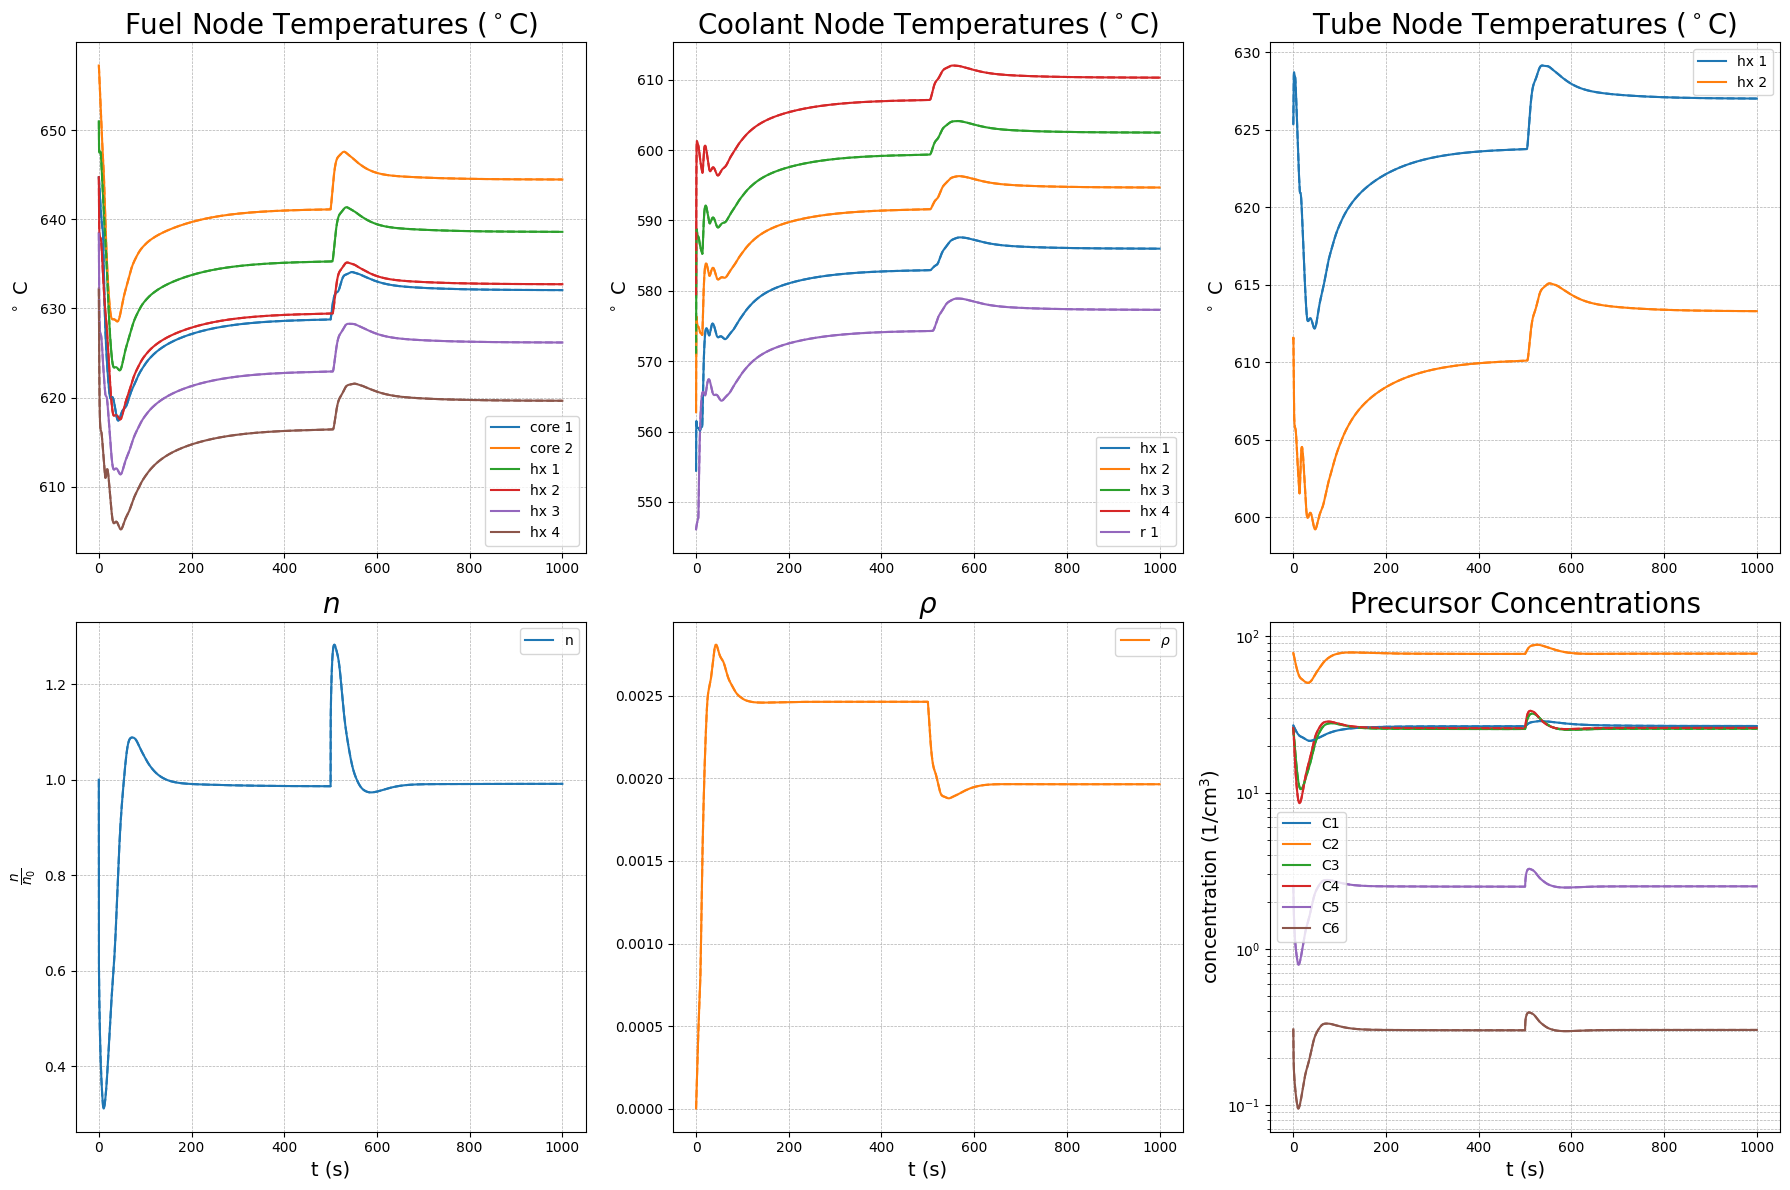

In [8]:
fig,axs = plt.subplots(2,3,figsize=(18,12))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

# function to update the style of each axis
def update_axis_style(ax, title, x_label='', y_label='', x_ticks=True):
    ax.set_title(title,fontsize=20)
    ax.set_xlabel(x_label,fontsize=14)
    ax.set_ylabel(y_label,fontsize=14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', which='both', bottom=x_ticks, top=False, labelbottom=x_ticks)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

# Fuel temperatures
sol_jit = np.array(sol_jit)
update_axis_style(axs[0, 0], r"Fuel Node Temperatures ($^\circ$C)", y_label=r"$^\circ$ C")
axs[0,0].plot(T,T_cf1.y_out,label="core 1",color=colors[0]) 
axs[0,0].plot(T,T_cf2.y_out,label="core 2",color=colors[1]) 
axs[0,0].plot(T,T_hf1.y_out,label="hx 1",color=colors[2])  
axs[0,0].plot(T,T_hf2.y_out,label="hx 2",color=colors[3])
axs[0,0].plot(T,T_hf3.y_out,label="hx 3",color=colors[4])
axs[0,0].plot(T,T_hf4.y_out,label="hx 4",color=colors[5]) 
axs[0,0].plot(T,df_simulink["core(:,18)"],color=colors[0],linestyle="--")
axs[0,0].plot(T,df_simulink["core(:,19)"],color=colors[1],linestyle="--")
axs[0,0].plot(T,df_simulink["hx(:,3)"],color=colors[2],linestyle="--")
axs[0,0].plot(T,df_simulink["hx(:,4)"],color=colors[3],linestyle="--")
axs[0,0].plot(T,df_simulink["hx(:,5)"],color=colors[4],linestyle="--")
axs[0,0].plot(T,df_simulink["hx(:,6)"],color=colors[5],linestyle="--")

# Coolant temperatures
update_axis_style(axs[0, 1], r"Coolant Node Temperatures ($^\circ$C)", y_label=r"$^\circ$ C")
axs[0, 1].plot(T, T_hc1.y_out, label=f"hx 1", color=colors[0])
axs[0, 1].plot(T, T_hc2.y_out, label=f"hx 2", color=colors[1])
axs[0, 1].plot(T, T_hc3.y_out, label=f"hx 3", color=colors[2])
axs[0, 1].plot(T, T_hc4.y_out, label=f"hx 4", color=colors[3])
axs[0, 1].plot(T, T_out_rc.y_out, label=f"r 1", color=colors[4])
axs[0,1].plot(T,df_simulink["hx(:,9)"],color=colors[0],linestyle="--")
axs[0,1].plot(T,df_simulink["hx(:,10)"],color=colors[1],linestyle="--")
axs[0,1].plot(T,df_simulink["hx(:,11)"],color=colors[2],linestyle="--")
axs[0,1].plot(T,df_simulink["hx(:,12)"],color=colors[3],linestyle="--")
axs[0,1].plot(T,df_simulink["radiator(:,3)"],color=colors[4],linestyle="--")

# Tube node temperatures
update_axis_style(axs[0, 2], r"Tube Node Temperatures ($^\circ$C)", y_label=r"$^\circ$ C")
axs[0,2].plot(T,T_ht1.y_out,label="hx 1",color=colors[0]) 
axs[0,2].plot(T,T_ht2.y_out,label="hx 2",color=colors[1]) 
axs[0,2].plot(T,df_simulink["hx(:,7)"],color=colors[0],linestyle="--")
axs[0,2].plot(T,df_simulink["hx(:,8)"],color=colors[1],linestyle="--")

# Precursor concentrations
update_axis_style(axs[1, 2], "Precursor Concentrations", x_label="t (s)", y_label=r"concentration (1/cm$^3$)")
axs[1, 2].plot(T, C1.y_out, label="C1", color=colors[0])
axs[1, 2].plot(T, C2.y_out, label="C2", color=colors[1])
axs[1, 2].plot(T, C3.y_out, label="C3", color=colors[2])
axs[1, 2].plot(T, C4.y_out, label="C4", color=colors[3])
axs[1, 2].plot(T, C5.y_out, label="C5", color=colors[4])
axs[1, 2].plot(T, C6.y_out, label="C6", color=colors[5])
axs[1,2].plot(T,df_simulink["core(:,5)"],color=colors[0],linestyle="--")
axs[1,2].plot(T,df_simulink["core(:,7)"],color=colors[1],linestyle="--")
axs[1,2].plot(T,df_simulink["core(:,9)"],color=colors[2],linestyle="--")
axs[1,2].plot(T,df_simulink["core(:,11)"],color=colors[3],linestyle="--")
axs[1,2].plot(T,df_simulink["core(:,13)"],color=colors[4],linestyle="--")
axs[1,2].plot(T,df_simulink["core(:,15)"],color=colors[5],linestyle="--")
axs[1, 2].set_yscale("log")

# Multiplication factor temp
update_axis_style(axs[1, 0], r"$n$", x_label="t (s)", y_label=r"$\frac{n}{n_0}$")
axs[1, 0].plot(T, sol_jit[:, 12], label="n", color='tab:blue')
axs[1,0].plot(T,df_simulink["core(:,4)"],color='tab:blue',linestyle="--")

# Reactivity
update_axis_style(axs[1, 1], r"$\rho$", x_label="t (s)")
axs[1, 1].plot(T, rho.y_out, label=r"$\rho$", color='tab:orange')
axs[1,1].plot(T,df_simulink["Gain"]+df_simulink["Gain1"],color='tab:orange',linestyle="--")

# Adding legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()


In [9]:
MSRE.get_dydt()

[0.0181704774505898*(-current_y(0) + current_y(1)) + 0.256292182093792*(-current_y(0) + past_y(-4.71 + t, 11, anchors(-4.71 + t))),
 29.878463436859*(37.78 - current_y(1)) + 4.76045254817907*(current_y(0) - current_y(1)),
 0.945852403920198*(-current_y(2) + current_y(6)) + 1.8644735369088*(-current_y(2) + past_y(-3.77 + t, 21, anchors(-3.77 + t))),
 0.945852403920198*(-current_y(2) + current_y(6)) + 1.8644735369088*(current_y(2) - current_y(3)),
 1.8644735369088*(current_y(3) - current_y(4)) + 0.945852403920198*(-current_y(4) + current_y(7)),
 0.945852403920198*(-current_y(4) + current_y(7)) + 1.8644735369088*(current_y(4) - current_y(5)),
 5.54283580016839*(current_y(2) - current_y(6)) + 2.61745023896841*(-current_y(6) + current_y(10)),
 5.54283580016839*(current_y(4) - current_y(7)) + 2.61745023896841*(-current_y(7) + current_y(8)),
 1.28444396919807*(current_y(7) - current_y(8)) + 4.03608587606233*(-current_y(8) + past_y(-8.24 + t, 0, anchors(-8.24 + t))),
 1.28444396919807*(current

In [10]:
P*n.y_out[-1]

7.9306342731348725

Errors

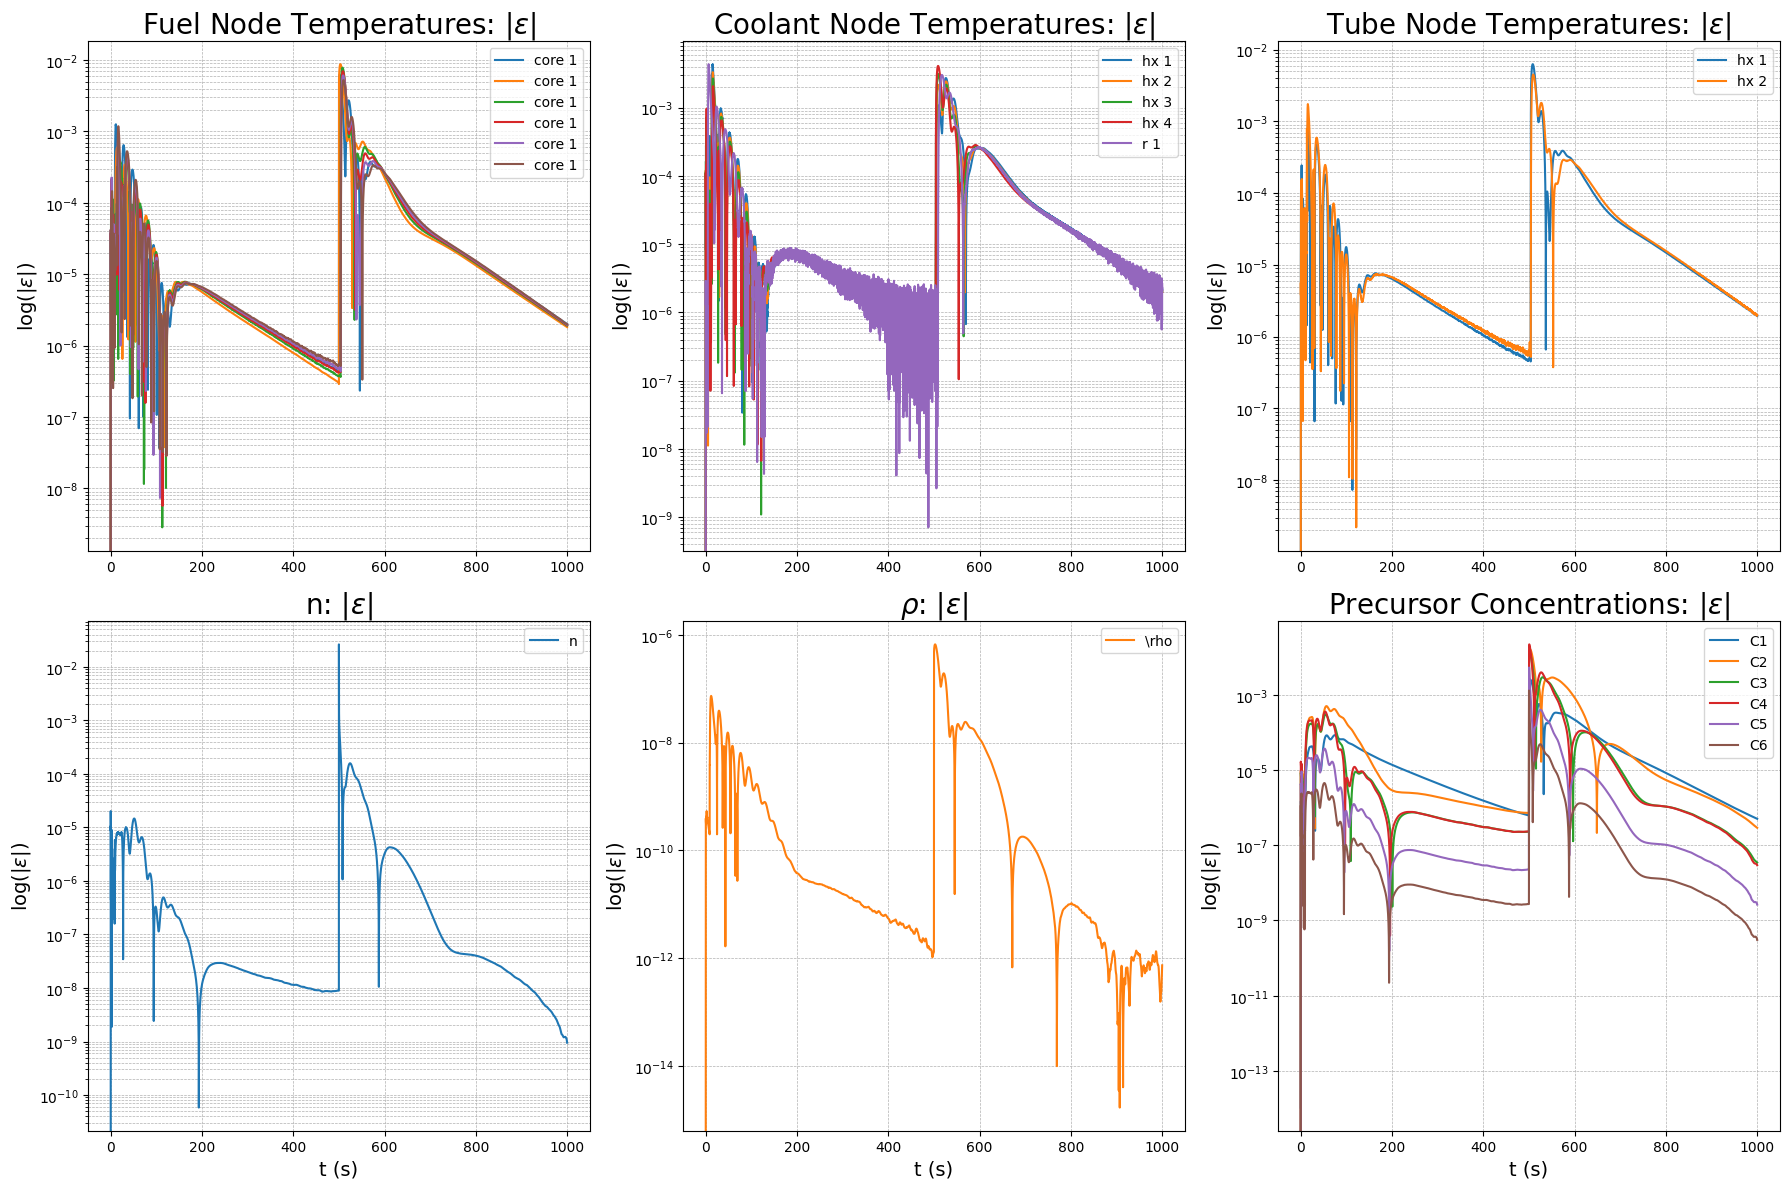

In [11]:
fig,axs = plt.subplots(2,3,figsize=(18,12))

# Set a professional color scheme
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

# Function to update the style of each axis
def update_axis_style(ax, title, x_label='', y_label='', x_ticks=True):
    ax.set_title(title,fontsize=20)
    ax.set_xlabel(x_label,fontsize=14)
    ax.set_ylabel(y_label,fontsize=14)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', which='both', bottom=x_ticks, top=False, labelbottom=x_ticks)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
    ax.set_yscale("log")

# Applying the updated style to the subplots
# Fuel temperatures
sol_jit = np.array(sol_jit)
update_axis_style(axs[0, 0], r"Fuel Node Temperatures: $|\epsilon|$", y_label=r"log($|\epsilon|$)")
axs[0,0].plot(T,pd.DataFrame.abs(T_cf1.y_out-df_simulink["core(:,18)"]),label="core 1",color=colors[0]) 
axs[0,0].plot(T,pd.DataFrame.abs(T_cf2.y_out-df_simulink["core(:,19)"]),label="core 1",color=colors[1]) 
axs[0,0].plot(T,pd.DataFrame.abs(T_hf1.y_out-df_simulink["hx(:,3)"]),label="core 1",color=colors[2])
axs[0,0].plot(T,pd.DataFrame.abs(T_hf2.y_out-df_simulink["hx(:,4)"]),label="core 1",color=colors[3])
axs[0,0].plot(T,pd.DataFrame.abs(T_hf3.y_out-df_simulink["hx(:,5)"]),label="core 1",color=colors[4])
axs[0,0].plot(T,pd.DataFrame.abs(T_hf4.y_out-df_simulink["hx(:,6)"]),label="core 1",color=colors[5]) 

# # Coolant temperatures
update_axis_style(axs[0, 1], r"Coolant Node Temperatures: $|\epsilon|$",y_label=r"log($|\epsilon|$)")
axs[0, 1].plot(T, pd.DataFrame.abs(T_hc1.y_out - df_simulink["hx(:,9)"]), label="hx 1", color=colors[0])
axs[0, 1].plot(T, pd.DataFrame.abs(T_hc2.y_out - df_simulink["hx(:,10)"]), label="hx 2", color=colors[1])
axs[0, 1].plot(T, pd.DataFrame.abs(T_hc3.y_out - df_simulink["hx(:,11)"]), label="hx 3", color=colors[2])
axs[0, 1].plot(T, pd.DataFrame.abs(T_hc4.y_out - df_simulink["hx(:,12)"]), label="hx 4", color=colors[3])
axs[0, 1].plot(T, pd.DataFrame.abs(T_out_rc.y_out - df_simulink["radiator(:,3)"]), label="r 1", color=colors[4])

# Tube Node Temperatures: Absolute Error
update_axis_style(axs[0, 2], r"Tube Node Temperatures: $|\epsilon|$", y_label=r"log($|\epsilon|$)")
axs[0, 2].plot(T, pd.DataFrame.abs(T_ht1.y_out - df_simulink["hx(:,7)"]), label="hx 1", color=colors[0])
axs[0, 2].plot(T, pd.DataFrame.abs(T_ht2.y_out - df_simulink["hx(:,8)"]), label="hx 2", color=colors[1])

# Precursor Concentrations: Absolute Error
update_axis_style(axs[1, 2], r"Precursor Concentrations: $|\epsilon|$", x_label="t (s)", y_label=r"log($|\epsilon|$)")
axs[1, 2].plot(T, pd.DataFrame.abs(C1.y_out - df_simulink["core(:,5)"]), label="C1", color=colors[0])
axs[1, 2].plot(T, pd.DataFrame.abs(C2.y_out - df_simulink["core(:,7)"]), label="C2", color=colors[1])
axs[1, 2].plot(T, pd.DataFrame.abs(C3.y_out - df_simulink["core(:,9)"]), label="C3", color=colors[2])
axs[1, 2].plot(T, pd.DataFrame.abs(C4.y_out - df_simulink["core(:,11)"]), label="C4", color=colors[3])
axs[1, 2].plot(T, pd.DataFrame.abs(C5.y_out - df_simulink["core(:,13)"]), label="C5", color=colors[4])
axs[1, 2].plot(T, pd.DataFrame.abs(C6.y_out - df_simulink["core(:,15)"]), label="C6", color=colors[5])

# # Multiplication factor temp
update_axis_style(axs[1, 0], r"n: $|\epsilon|$", x_label="t (s)", y_label=r"log($|\epsilon|$)")
axs[1, 0].plot(T, pd.DataFrame.abs(n.y_out - df_simulink["core(:,4)"]), label="n", color='tab:blue')

# # Reactivity
update_axis_style(axs[1, 1], r"$\rho$: $|\epsilon|$", x_label="t (s)",y_label=r"log($|\epsilon|$)")
axs[1, 1].plot(T, pd.DataFrame.abs(rho.y_out-df_simulink["Gain"]-df_simulink["Gain1"]), label=r"\rho", color='tab:orange')

# Adding legends
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()
